# Compute Pairwise Accuracies

## Preliminaries (imports)

In [1]:
import utils
import data_utils
import train_utils

import matplotlib
matplotlib.rcParams["text.usetex"] = False
import matplotlib.pyplot as plt

import numpy as np

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utility functions

In [2]:
def compute_pairwise_accuracies(config):
    train_loaders, test_loaders = data_utils.create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])

    pairwise_accuracies = np.zeros((config['num_tasks'], config['num_tasks']), dtype=np.float64)
    for i, (train_loader_1, test_loader_1) in enumerate(zip(train_loaders, test_loaders)):
        for j, (_, test_loader_2) in enumerate(zip(train_loaders, test_loaders)):

            model_path = '0_SeparateModel/SeparateModel_{}_{}deg_MNIST.pth'.format(
                config['model_name'],
                train_loader_1['rot']
                )
            model = utils.load_model(path=model_path)

            accuracy_1 = train_utils.evaluate_model(model, test_loader_1['loader'])  #used only for displaying the accuracy on the rotation the model was trained on
            accuracy_2 = train_utils.evaluate_model(model, test_loader_2['loader'])
            print('Accuracies - {}°-specific {} tested on {}°: {} | tested on {}°: {}'.format(
                config['model_name'],
                test_loader_1['rot'],
                test_loader_1['rot'],
                accuracy_1,
                test_loader_2['rot'],
                accuracy_2)
                )

            pairwise_accuracies[i, j] = accuracy_2

    return pairwise_accuracies

In [ ]:
def plot_pairwise_accuracies(pairwise_accuracies, config):
    # rotations = []  #TODO put the list of rotations inside config json
    # for train_loader in train_loaders:
    #     rotations.append(train_loader['rot'])

    fig, ax = plt.subplots()

    im = ax.imshow(pairwise_accuracies, origin='upper', cmap='Blues')
    im.norm.autoscale([0, 1])
    ax.set_ylabel(f"Train rotation angle", fontsize=15)
    ax.set_xlabel(f"Test rotation angle", fontsize=15)

    ax.set_title('Pairwise accuracies', fontsize=18)

    ax.set_xticks(list(range(len(pairwise_accuracies))), config['rotations'], fontsize=15, rotation=45)
    ax.set_yticks(list(range(len(pairwise_accuracies))), config['rotations'], fontsize=15, rotation=0)

    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=15)
    plt.tight_layout()

    save_path = '0_SeparateModel/SeparateModel_{}_pairwise_accuracies_MNIST.pdf'.format(config['model_name'])
    if save_path is not None:
        plt.savefig(save_path, dpi=300)

    plt.show()

In [ ]:
def plot_accuracies_over_angles(pairwise_accuracies, config):
    # rotations = []  #TODO put the list of rotations inside config json
    # for train_loader in train_loaders:
    #     rotations.append(train_loader['rot'])

    for i, accuracies_of_model in enumerate(pairwise_accuracies):
        plt.plot(config['rotations'], accuracies_of_model, marker='o', label='{}°-specific'.format(config['rotations'][i]))

    plt.xlabel('Rotation angles', fontsize=15)
    plt.ylabel('Test accuracy', fontsize=15)
    plt.ylim(0, 1)
    plt.tick_params(labelsize=15)
    plt.xticks(config['rotations'])
    plt.legend()
    plt.savefig('0_SeparateModel/SeparateModel_{}_accuracies_over_angles.pdf'.format(config['model_name']))
    plt.show()

In [ ]:
def plot_accuracies_over_angles_BIS(pairwise_accuracies, config):

    # rotations = []  #TODO put the list of rotations inside config json
    # for train_loader in train_loaders:
    #     rotations.append(train_loader['rot'])

    for i, accuracies_of_model in enumerate(pairwise_accuracies):
        print('original list of accuracies', accuracies_of_model)
        print('shifted list of accuracies', np.roll(accuracies_of_model, -i))
        print()
        plt.plot(config['rotations'][:-1], np.roll(accuracies_of_model, -i)[:-1], marker='o', label='{}°-specific'.format(config['rotations'][i]))

    plt.xlabel('training rotation angle+i×{}°'.format(config['per_task_rotation']), fontsize=15)
    plt.ylabel('Test accuracy', fontsize=15)
    plt.ylim(0, 1)
    plt.tick_params(labelsize=15)
    shifted_rotations_ticks = np.roll(config['rotations'], -1)
    print('shifted rotations', shifted_rotations_ticks)
    plt.xticks(config['rotations'][:-1], shifted_rotations_ticks[:-1])
    plt.legend()
    plt.savefig('0_SeparateModel/SeparateModel_SimpleNN_accuracies_over_angles_BIS.pdf')
    plt.show()

In [ ]:
import matplotlib
matplotlib.rcParams["text.usetex"] = False


def plot_accuracies_over_angles_BIS_AVERAGED(pairwise_accuracies, config):

    # rotations = []  #TODO put the list of rotations inside config json
    # for train_loader in train_loaders:
    #     rotations.append(train_loader['rot'])
    rotations = config['rotations']

    accs = np.zeros((len(pairwise_accuracies)-1, config['num_tasks']))
    for i, accuracies_of_model in enumerate(pairwise_accuracies):
        print('original list of accuracies', accuracies_of_model)
        print('shifted list of accuracies', np.roll(accuracies_of_model, -i))
        print()
        #plt.plot(rotations[:-1], np.roll(accuracies_of_model, -i)[:-1], marker='o', label='{}°-specific'.format(rotations[i]))
        accs[i] = np.roll(accuracies_of_model, -i)[:-1]

    accs_mean = np.mean(accs, axis=0)
    plt.plot(rotations[:-1], accs_mean)
    plt.fill_between(rotations[:-1], accs_mean-np.std(accs, axis=0), accs_mean+np.std(accs, axis=0), color='#888888', alpha=0.4)

    plt.xlabel('training rotation angle+i×{}°'.format(config['per_task_rotation']), fontsize=15)
    plt.ylabel('Test accuracy', fontsize=15)
    plt.ylim(0, 1)
    plt.tick_params(labelsize=15)
    shifted_rotations_ticks = np.roll(rotations, -1)
    print('shifted rotations', shifted_rotations_ticks)
    plt.xticks(rotations[:-1], shifted_rotations_ticks[:-1])
    plt.legend()
    plt.savefig('0_SeparateModel/{}_{}_accuracies_over_angles_BIS_AVERAGED.pdf'.format(config['setting'], config['model_name']))
    plt.show()

## SimpleNN

In [3]:
config = {
    # ---COMMON----
    'setting': 'SeparateModel',
    'model_name': 'SimpleNN',
    'num_tasks': 8, 'per_task_rotation': 45,
    # 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    # 'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    # 'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'rounds': 10
}
config['rotations'] = [(task-1) * config['per_task_rotation'] for task in range(config['num_tasks'])]  #consistent with the code of `create_rotated_mnist`
print(config['rotations'])


[-45, 0, 45, 90, 135, 180, 225, 270]


In [ ]:
pairwise_accuracies = compute_pairwise_accuracies(config)

Accuracies - -45°-specific SimpleNN tested on -45°: 0.972 | tested on -45°: 0.972
Accuracies - -45°-specific SimpleNN tested on -45°: 0.972 | tested on 0°: 0.4603
Accuracies - -45°-specific SimpleNN tested on -45°: 0.972 | tested on 45°: 0.1356
Accuracies - -45°-specific SimpleNN tested on -45°: 0.972 | tested on 90°: 0.2036
Accuracies - -45°-specific SimpleNN tested on -45°: 0.972 | tested on 135°: 0.3097
Accuracies - -45°-specific SimpleNN tested on -45°: 0.972 | tested on 180°: 0.1793
Accuracies - -45°-specific SimpleNN tested on -45°: 0.972 | tested on 225°: 0.1185
Accuracies - -45°-specific SimpleNN tested on -45°: 0.972 | tested on 270°: 0.3461
Accuracies - 0°-specific SimpleNN tested on 0°: 0.9726 | tested on -45°: 0.3538
Accuracies - 0°-specific SimpleNN tested on 0°: 0.9726 | tested on 0°: 0.9726
Accuracies - 0°-specific SimpleNN tested on 0°: 0.9726 | tested on 45°: 0.4482
Accuracies - 0°-specific SimpleNN tested on 0°: 0.9726 | tested on 90°: 0.118
Accuracies - 0°-specific S

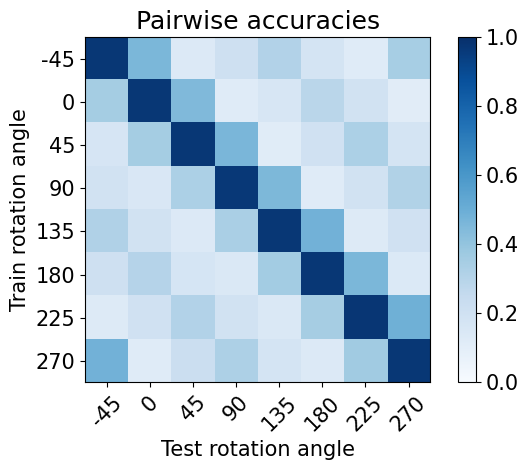

In [ ]:
plot_pairwise_accuracies(pairwise_accuracies, config)

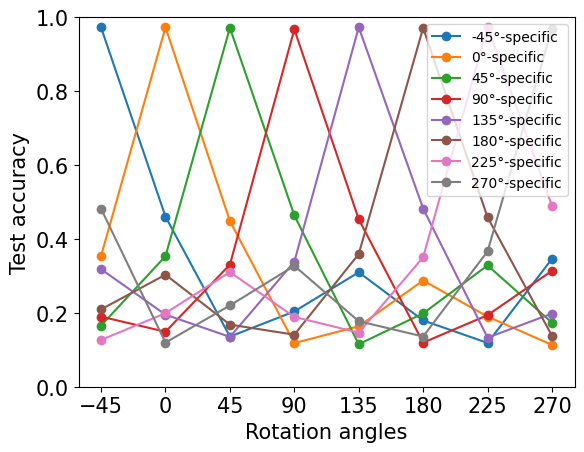

In [ ]:
plot_accuracies_over_angles(pairwise_accuracies, config)

original list of accuracies [0.972  0.4603 0.1356 0.2036 0.3097 0.1793 0.1185 0.3461]
shifted list of accuracies [0.972  0.4603 0.1356 0.2036 0.3097 0.1793 0.1185 0.3461]

original list of accuracies [0.3538 0.9726 0.4482 0.118  0.1636 0.2873 0.1899 0.1132]
shifted list of accuracies [0.9726 0.4482 0.118  0.1636 0.2873 0.1899 0.1132 0.3538]

original list of accuracies [0.1655 0.3532 0.9711 0.4636 0.115  0.1984 0.3283 0.1733]
shifted list of accuracies [0.9711 0.4636 0.115  0.1984 0.3283 0.1733 0.1655 0.3532]

original list of accuracies [0.1896 0.1487 0.3304 0.9669 0.4533 0.1193 0.1936 0.3137]
shifted list of accuracies [0.9669 0.4533 0.1193 0.1936 0.3137 0.1896 0.1487 0.3304]

original list of accuracies [0.3179 0.195  0.1348 0.3381 0.9724 0.482  0.1327 0.1981]
shifted list of accuracies [0.9724 0.482  0.1327 0.1981 0.3179 0.195  0.1348 0.3381]

original list of accuracies [0.2093 0.3031 0.1681 0.1408 0.3591 0.9708 0.4584 0.1378]
shifted list of accuracies [0.9708 0.4584 0.1378 0.209

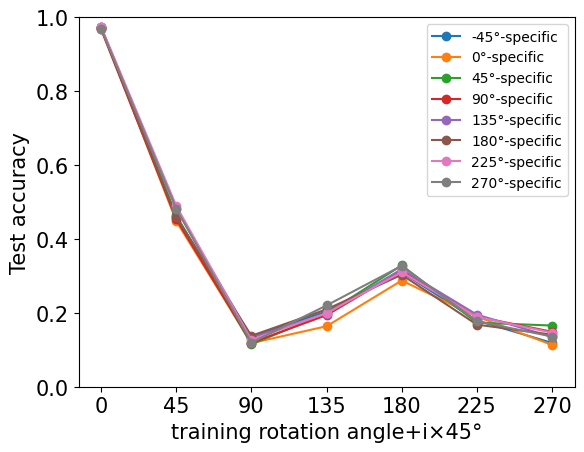

In [ ]:
plot_accuracies_over_angles_BIS(pairwise_accuracies, config)

## SimpleCNN

In [ ]:
config = {
    # ---COMMON----
    'setting': 'SeparateModel',
    'model_name': 'SimpleCNN',
    'num_tasks': 8, 'per_task_rotation': 45,
    # 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    # 'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    # 'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'rounds': 10
}

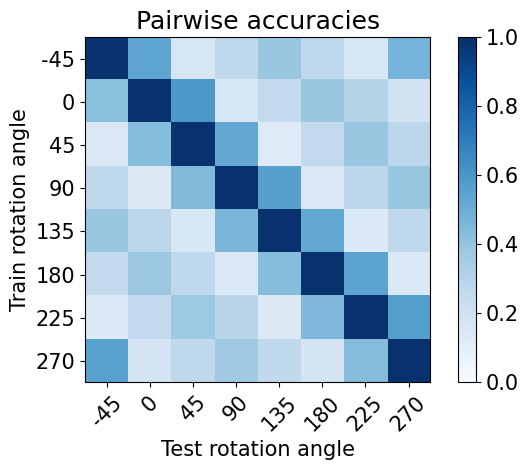

In [ ]:
plot_pairwise_accuracies(pairwise_accuracies, config)

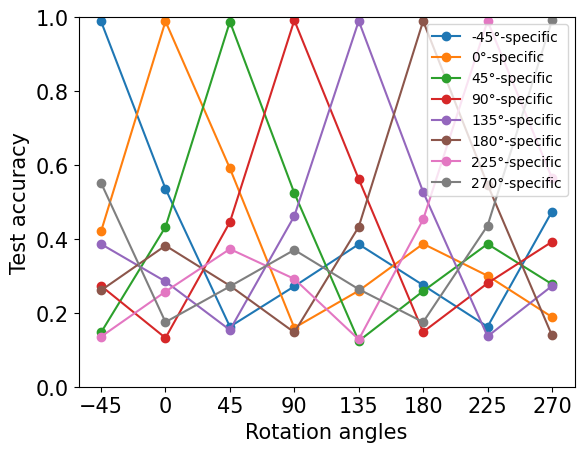

In [ ]:
plot_accuracies_over_angles(pairwise_accuracies, config)

original list of accuracies [0.9883 0.5356 0.1624 0.2717 0.3855 0.2747 0.1625 0.4739]
shifted list of accuracies [0.9883 0.5356 0.1624 0.2717 0.3855 0.2747 0.1625 0.4739]

original list of accuracies [0.4204 0.9887 0.5908 0.1594 0.2597 0.3866 0.3002 0.1886]
shifted list of accuracies [0.9887 0.5908 0.1594 0.2597 0.3866 0.3002 0.1886 0.4204]

original list of accuracies [0.1469 0.4323 0.9876 0.524  0.1237 0.2587 0.3862 0.2775]
shifted list of accuracies [0.9876 0.524  0.1237 0.2587 0.3862 0.2775 0.1469 0.4323]

original list of accuracies [0.2727 0.132  0.4454 0.9915 0.5617 0.1483 0.28   0.3921]
shifted list of accuracies [0.9915 0.5617 0.1483 0.28   0.3921 0.2727 0.132  0.4454]

original list of accuracies [0.3859 0.2847 0.1535 0.4617 0.9897 0.527  0.1362 0.2726]
shifted list of accuracies [0.9897 0.527  0.1362 0.2726 0.3859 0.2847 0.1535 0.4617]

original list of accuracies [0.2608 0.3818 0.2733 0.147  0.4327 0.9894 0.5468 0.1387]
shifted list of accuracies [0.9894 0.5468 0.1387 0.260

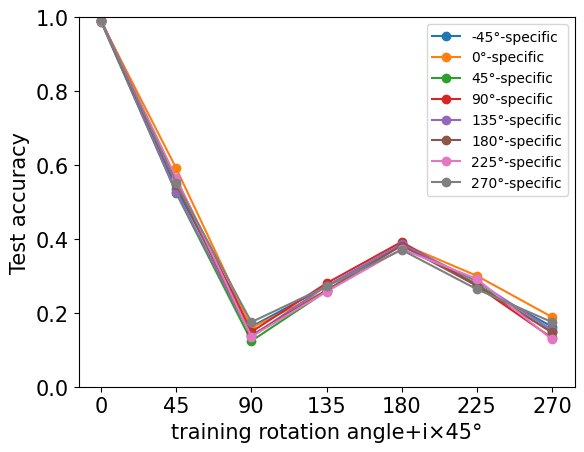

In [ ]:
plot_accuracies_over_angles_BIS(pairwise_accuracies, config)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(8, 7)
original list of accuracies [0.9883 0.5356 0.1624 0.2717 0.3855 0.2747 0.1625 0.4739]
shifted list of accuracies [0.9883 0.5356 0.1624 0.2717 0.3855 0.2747 0.1625 0.4739]

original list of accuracies [0.4204 0.9887 0.5908 0.1594 0.2597 0.3866 0.3002 0.1886]
shifted list of accuracies [0.9887 0.5908 0.1594 0.2597 0.3866 0.3002 0.1886 0.4204]

original list of accuracies [0.1469 0.4323 0.9876 0.524  0.1237 0.2587 0.3862 0.2775]
shifted list of accuracies [0.9876 0.524  0.1237 0.2587 0.3862 0.2775 0.1469 0.4323]

original list of accuracies [0.2727 0.132  0.4454 0.9915 0.5617 0.1483 0.28   0.3921]
shifted list of accuracies [0.9915 0.5617 0.1483 0.28   0.3921 0.2727 0.132  0.4454]

original list of accuracies [0.3859 0.2847 0.1535 0.4617 0.9897 0.527  0.1362 0.2726]
shifted list of accuracies [0.9897 0.527  0.1362 0.2726 0.3859 0.2847 0.1535 0.4617]

original list of accuracies [0.2608 0.3818 0.2733 0.147  0.4327 0.9894 0.5468 0.1387]
shifted list of accuracies [0.9894 0.5468 0.138

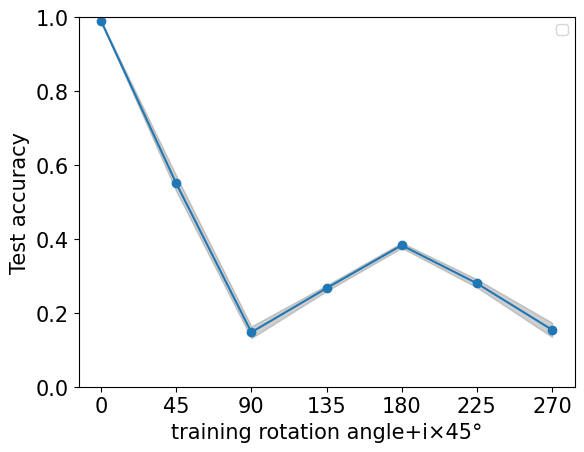

In [ ]:
plot_accuracies_over_angles_BIS_AVERAGED(pairwise_accuracies, config)

# Compute pairwise predictions

## SimpleNN

In [4]:
config = {
    # ---COMMON----
    'setting': 'SeparateModel',
    'model_name': 'SimpleNN',
    'num_tasks': 8, 'per_task_rotation': 45,
    # 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    # 'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    # 'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'rounds': 10
}
config['rotations'] = [(task-1) * config['per_task_rotation'] for task in range(config['num_tasks'])]  #consistent with the code of `create_rotated_mnist`
print(config['rotations'])


[-45, 0, 45, 90, 135, 180, 225, 270]


In [5]:
import torch

def get_predictions(model, test_loader, compute_probabilities=True):
    inpts, targets, predictions, logits = [], [], [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)

            lgts = outputs
            if compute_probabilities:
                lgts = torch.nn.functional.log_softmax(outputs, dim=1)

            max, predicted = torch.max(lgts, 1)

            inpts.extend(inputs)
            targets.extend(labels.detach())
            predictions.extend(predicted.detach())
            logits.extend(max)  #TODO beware of the fact that the logits in the case of SimpleNN are not actual logits!

            print(max[0], predicted[0], max[0]+predicted[0])

    return inpts, targets, predictions, logits

In [137]:
# load dataloaders
utils.set_seed(0)
train_loaders, test_loaders = data_utils.create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])

test_loader_1 = test_loaders[1]
print('rotation_1', test_loader_1['rot'])
test_loader_2 = test_loaders[2]
print('rotation_2', test_loader_2['rot'])

# load model
model_path = '0_SeparateModel/SimpleNN/SeparateModel_{}_{}deg_MNIST.pth'.format(
    config['model_name'],
    test_loader_1['rot']
    )
model = utils.load_model(path=model_path)

# compute predictions
inputs_1, targets_1, predictions_1, logits_1 = get_predictions(model, test_loader_1['loader'])
inputs_2, targets_2, predictions_2, logits_2 = get_predictions(model, test_loader_2['loader'])

Random seed set as 0
0
45
tensor(-8.1062e-06) tensor(7) tensor(7.0000)
tensor(-1.8954e-05) tensor(2) tensor(2.0000)
tensor(-4.7684e-07) tensor(2) tensor(2.0000)
tensor(-9.6559e-06) tensor(1) tensor(1.0000)
tensor(-0.0102) tensor(4) tensor(3.9898)
tensor(-0.0003) tensor(1) tensor(0.9997)
tensor(-0.0005) tensor(6) tensor(5.9995)
tensor(-2.8133e-05) tensor(7) tensor(7.0000)
tensor(-0.0002) tensor(7) tensor(6.9998)
tensor(-4.6729e-05) tensor(0) tensor(-4.6729e-05)
tensor(-0.0170) tensor(3) tensor(2.9830)
tensor(-0.0002) tensor(1) tensor(0.9998)
tensor(-2.0146e-05) tensor(8) tensor(8.0000)
tensor(-0.0005) tensor(7) tensor(6.9995)
tensor(0.) tensor(0) tensor(0.)
tensor(-1.4186e-05) tensor(9) tensor(9.0000)
tensor(-0.0041) tensor(8) tensor(7.9959)
tensor(-2.3246e-05) tensor(3) tensor(3.0000)
tensor(-0.0004) tensor(8) tensor(7.9996)
tensor(-0.0004) tensor(1) tensor(0.9996)
tensor(-2.3842e-07) tensor(2) tensor(2.0000)
tensor(-1.0967e-05) tensor(8) tensor(8.0000)
tensor(-3.5763e-07) tensor(5) te

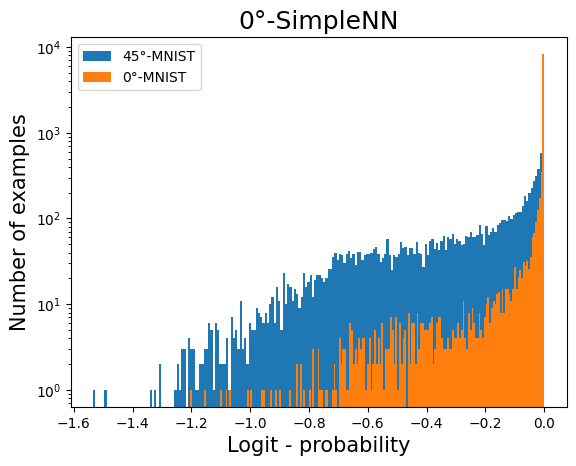

In [8]:
plt.hist(logits_2, bins=200, label='45°-MNIST')
plt.hist(logits_1, bins=200, label='0°-MNIST')

plt.title('0°-SimpleNN', fontsize=18)
plt.ylabel('Number of examples', fontsize=15)
plt.xlabel('Logit - probability', fontsize=15)
plt.yscale('log')
plt.legend()
plt.savefig('0_SeparateModel/SeparateModel_SimpleNN_-0deg_logits_comparison_0deg_vs_45deg.pdf')
plt.show()

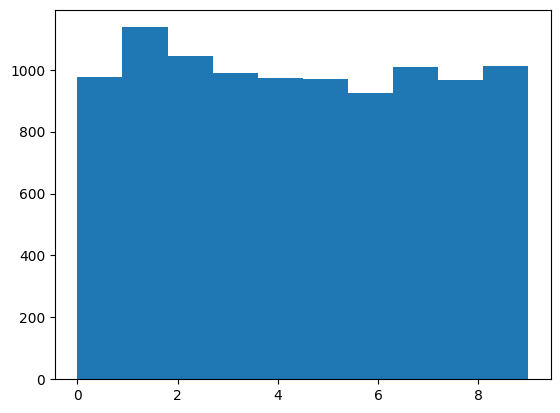

In [9]:
plt.hist(predictions_1)
plt.show()

In [10]:
assert targets_1 == targets_2  # because `shuffle` is set to `False` in `test_loader`

In [11]:
print(len(targets_1))

10000


In [12]:
m1 = np.array(targets_1)==np.array(predictions_1)
m2 = np.array(targets_2)==np.array(predictions_2)

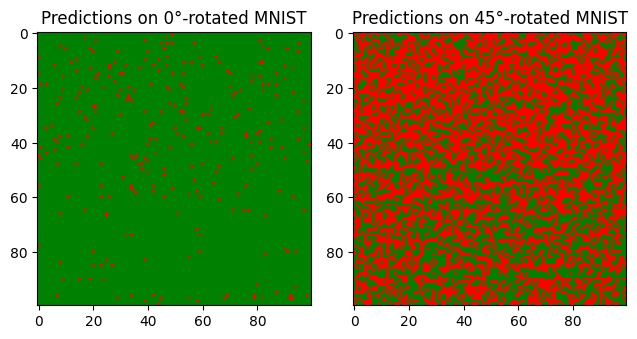

In [71]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(1, 2)

cmap = ListedColormap(['red', 'green'])

#ax[0].pcolormesh(m1.reshape(100, 100), cmap=cmap, edgecolors='white', linewidth=0.005)
ax[0].imshow(m1.reshape((100, 100)), cmap=cmap)
ax[0].set_title('Predictions on {}°-rotated MNIST'.format(0))

ax[1].imshow(m2.reshape((100, 100)), cmap=cmap)
ax[1].set_title('Predictions on {}°-rotated MNIST'.format(45))
#ax[1].grid(color='w', linewidth=2)

#fig.suptitle('(green) Correctly vs (red) Wrongly predicted examples - model trained on {}°-rotated MNIST'.format(0))
plt.savefig('0_SeparateModel/{}_{}_overall_predictions_{}deg-mnist_vs_{}deg-mnist.pdf'.format(
    config['setting'],
    config['model_name'],
    0,
    45
), bbox_inches='tight')
plt.show()

<BarContainer object of 10 artists>

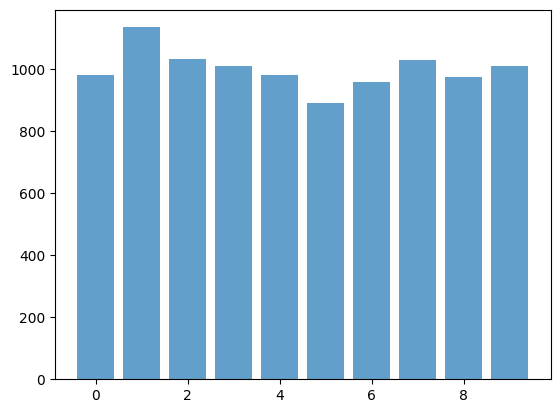

In [15]:
labels = [label for label in targets_1]
unique_labels, counts = torch.unique(torch.tensor(labels), return_counts=True)

plt.bar(unique_labels, counts, align='center', alpha=0.7)

### tests on probabilities (after `torch.nn.functional.log_softmax(outputs, dim=1)`)

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == "":


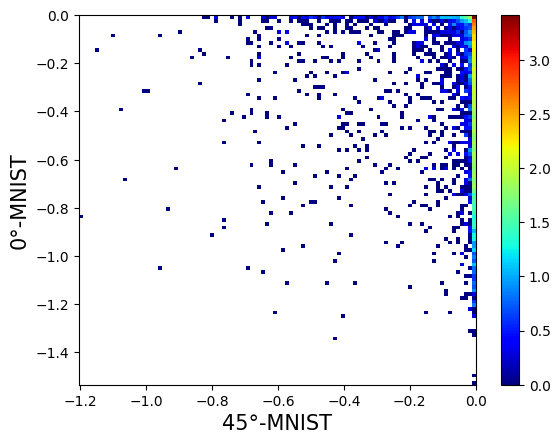

In [17]:
H, xedges, yedges = np.histogram2d(np.array(logits_1),np.array(logits_2),bins=100) #,range=histRange)
#H, xedges, yedges = np.histogram2d(m1,m2,bins=10) #,range=histRange)
#print(xedges, yedges)

# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
 
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
# Log
Hmasked = np.log10(Hmasked)     

# Plot 2D histogram using pcolor
fig2 = plt.figure()
#plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')
plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')
plt.colorbar()
#plt.xticks(range(0,20,200), range(10))
#plt.yticks(range(10))

plt.title('')
plt.ylabel('0°-MNIST', fontsize=15)
plt.xlabel('45°-MNIST', fontsize=15)
path = '0_SeparateModel/{}_{}_{}deg_logits_{}deg-MNIST_vs_{}deg-MNIST.pdf'.format(
    config['setting'],
    config['model_name'],
    0,
    0,
    45
)
plt.savefig(path)
plt.show()

[ True  True  True ...  True  True  True]
[7 2 1 ... 4 5 6]
(9726,)


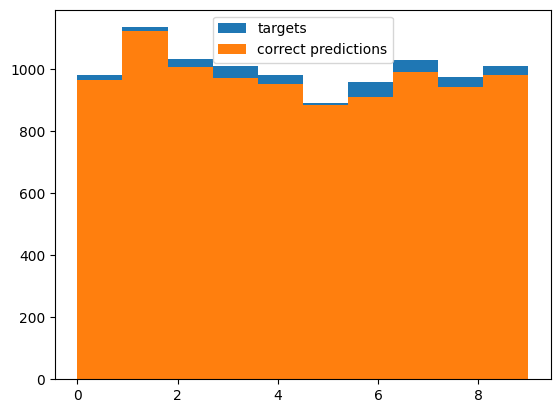

[False False  True ...  True  True  True]
[1 1 9 ... 4 5 6]
(4482,)


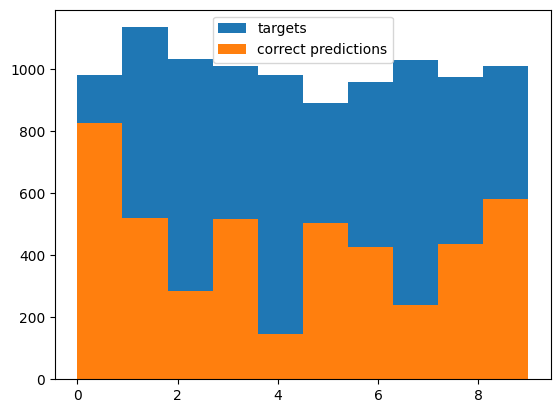

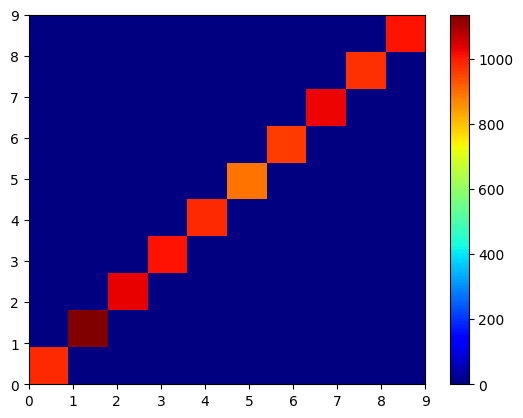

In [18]:
print(m1)
correctly_classified_1 = np.array(targets_1)[m1]
print(correctly_classified_1)
print(correctly_classified_1.shape)

plt.hist(targets_1, bins=10, label='targets')
plt.hist(correctly_classified_1, bins=10, label='correct predictions')
plt.legend()
plt.show()

print(m2)
correctly_classified_2 = np.array(targets_2)[m2]
print(correctly_classified_2)
print(correctly_classified_2.shape)

plt.hist(targets_2, bins=10, label='targets')
plt.hist(correctly_classified_2, bins=10, label='correct predictions')
plt.legend()
plt.show()


plt.hist2d(targets_1, targets_2, bins=10, cmap='jet')
plt.colorbar()
plt.show()

[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]
[False False  True ...  True  True  True]
[ True  True False ... False False False]


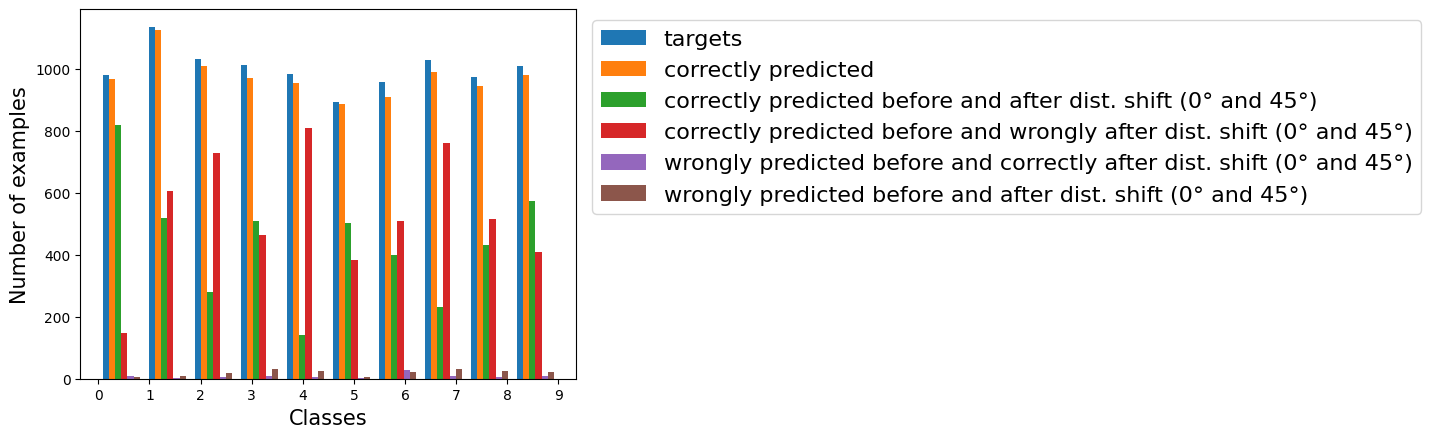

In [19]:
np_targets_1 = np.array(targets_1)
np_targets_2 = np.array(targets_2)
np_preds_1 = np.array(predictions_1)
np_preds_2 = np.array(predictions_2)

print(np_targets_1)
print(np_targets_2)
assert np.all(np.equal(np_targets_1, np_targets_2))

bien_bien_preds = np.logical_and(np_preds_1==np_targets_1, np_preds_2==np_targets_2)
bien_mal_preds = np.logical_and(np_preds_1==np_targets_1, np_preds_2!=np_targets_2)
mal_bien_preds = np.logical_and(np_preds_1!=np_targets_1, np_preds_2==np_targets_2)
mal_mal_preds = np.logical_and(np_preds_1!=np_targets_1, np_preds_2!=np_targets_2)
print(bien_bien_preds)
print(bien_mal_preds)


plt.hist(
        (np_targets_1,
         np_targets_1[m1],
         np_targets_1[bien_bien_preds],
         np_targets_1[bien_mal_preds],
         np_targets_1[mal_bien_preds],
         np_targets_1[mal_mal_preds]),
         bins=10,
         label=('targets',
                'correctly predicted',
                'correctly predicted before and after dist. shift (0° and 45°)',
                'correctly predicted before and wrongly after dist. shift (0° and 45°)',
                'wrongly predicted before and correctly after dist. shift (0° and 45°)',
                'wrongly predicted before and after dist. shift (0° and 45°)')
)
#plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=16)
plt.xlabel('Classes', fontsize=15)
plt.ylabel('Number of examples', fontsize=15)
plt.xticks(range(10))
plt.savefig('0_SeparateModel/SeparateModel_SimpleNN_0deg_predictions_hist.pdf', bbox_inches='tight')
plt.show()

[False False False ... False False False]


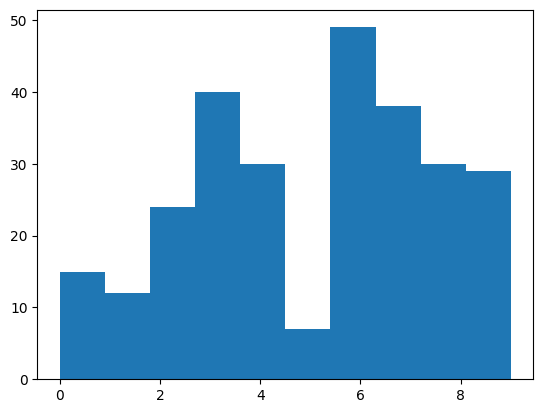

In [20]:
print(bien_bien_preds==bien_mal_preds)
plt.hist(np_targets_1[bien_bien_preds==bien_mal_preds])
plt.show()

#### predictions and logits/probabilities histograms

In [112]:
def plot_hist2d(a, b, what, ylabel, xlabel, bins, cmap, vmax, xlim, ylim, deg_in, deg_out, log, config):
    H, xedges, yedges = np.histogram2d(a,b,bins=bins) #,range=histRange)
    #H, xedges, yedges = np.histogram2d(m1,m2,bins=10) #,range=histRange)
    #print(xedges, yedges)

    # H needs to be rotated and flipped
    #H = np.rot90(H)
    #H = np.flipud(H)
    
    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    # Log
    if log is True:
        Hmasked = np.log10(Hmasked)     

    # Plot 2D histogram using pcolor
    fig2 = plt.figure()
    #plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')
    plt.pcolormesh(xedges,yedges,Hmasked, cmap=cmap, vmin=0, vmax=vmax)
    plt.colorbar()
    #plt.xticks(range(0,20,200), range(10))
    #plt.yticks(range(10))

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.xlim(ylim)

    plt.title('{}°-SimpleNN model'.format(deg_in), fontsize=18)
    plt.ylabel('({}°-MNIST) {}'.format(deg_in, ylabel), fontsize=15)
    plt.xlabel('({}°-MNIST) {}'.format(deg_out, xlabel), fontsize=15)
    #path = '0_SeparateModel/SeparateModel_SimpleNN_{}deg_how-correct-preds-in-{}deg-MNIST-are-classified-in-{}deg-MNIST.pdf'.format(
    path = '0_SeparateModel/SeparateModel_SimpleNN_{}deg_{}_{}deg_in_{}deg_out.pdf'.format(
        deg_in,
        what,
        deg_in,
        deg_out 
    )
    plt.savefig(path,bbox_inches='tight')
    plt.show()

##### predictions histograms

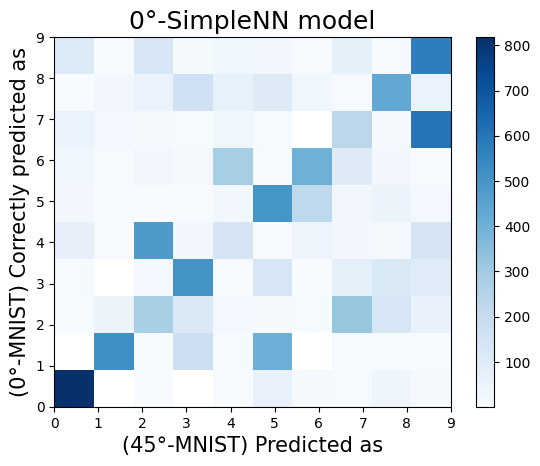

In [22]:
# 1. Take all the correctly classified examples in 0°-MNIST
# 2. Then, look how they have been predicted in the case of 45°-MNIST
a = np_preds_1[m1]  # correctly classified examples in 0°-MNIST
b = np_preds_2[m1]  # how the correctly predicted examples in 0°-MNIST are predicted when they are rotated by 45°

assert a.shape==b.shape

#bien: correctly predicted
#how: how they are predicted
plot_hist2d(a, b, what='bien_how_preds', ylabel='Correctly predicted as', xlabel='Predicted as', bins=10, cmap='Blues', deg_in=0, deg_out=45, log=False, config=None)

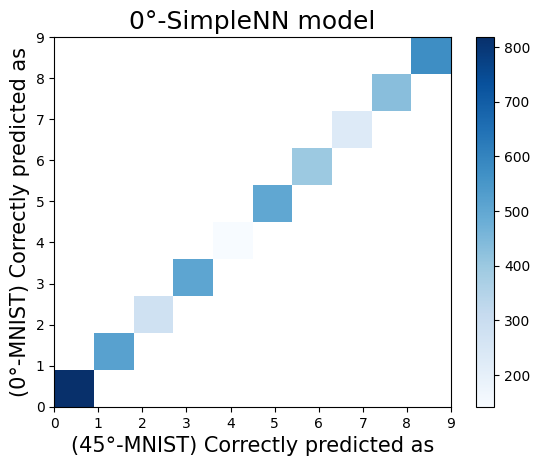

In [23]:
a = np_preds_1[bien_bien_preds]  # how correctly predicted examples in 0°-MNIST
b = np_preds_2[bien_bien_preds]  # how the correctly predicted examples in 0°-MNIST are correctly predicted when they are rotated by 45°
# it's useless, but is here (to stay!)

assert a.shape==b.shape

plot_hist2d(a, b, what='bien_bien_preds', bins=10, ylabel='Correctly predicted as', xlabel='Correctly predicted as', cmap='Blues', deg_in=0, deg_out=45, log=False, config=None)

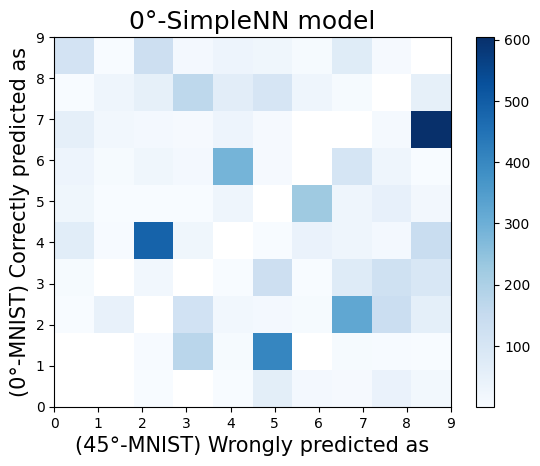

In [24]:
a = np_preds_1[bien_mal_preds]  # how correctly predicted examples in 0°-MNIST
b = np_preds_2[bien_mal_preds]  # how the correctly predicted examples in 0°-MNIST are wrongly predicted when they are rotated by 45°

assert a.shape==b.shape

plot_hist2d(a, b, what='bien_mal_preds', ylabel='Correctly predicted as', xlabel='Wrongly predicted as', bins=10, cmap='Blues', deg_in=0, deg_out=45, log=False, config=None)

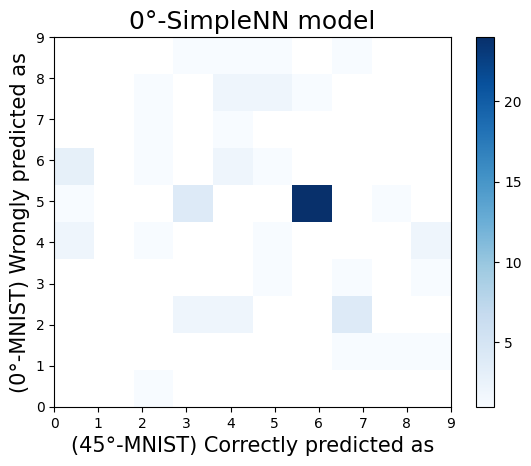

In [346]:
a = np_preds_1[mal_bien_preds]  # how wrongly predicted examples in 0°-MNIST
b = np_preds_2[mal_bien_preds]  # how the wrongly predicted examples in 0°-MNIST are correctly predicted when they are rotated by 45°

assert a.shape==b.shape

plot_hist2d(a, b, what='mal_bien_preds', ylabel='Wrongly predicted as', xlabel='Correctly predicted as', bins=10, cmap='Blues', deg_in=0, deg_out=45, log=False, config=None)

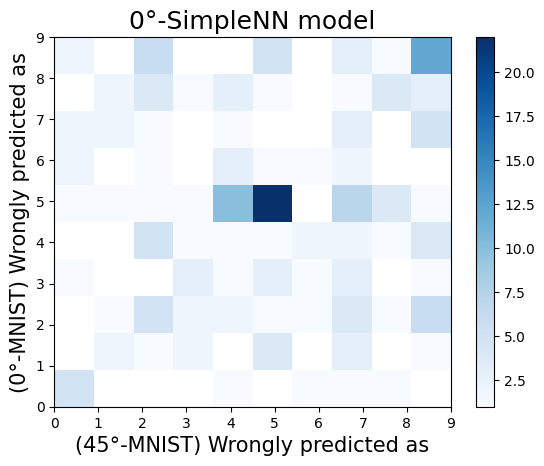

In [25]:
a = np_preds_1[mal_mal_preds]  # how wrongly predicted examples in 0°-MNIST
b = np_preds_2[mal_mal_preds]  # how the correctly predicted examples in 0°-MNIST are predicted when they are rotated by 45°

assert a.shape==b.shape

plot_hist2d(a, b, what='mal_mal_preds', ylabel='Wrongly predicted as', xlabel='Wrongly predicted as', bins=10, cmap='Blues', deg_in=0, deg_out=45, log=False, config=None)

##### logits/probabilities histograms

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


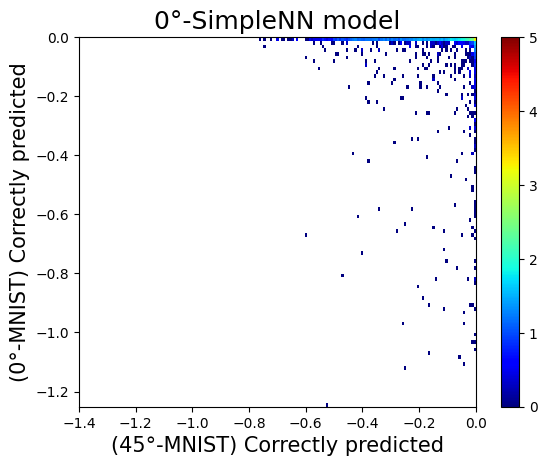

In [113]:
a = np.array(logits_1)[bien_bien_preds]
b = np.array(logits_2)[bien_bien_preds]

assert a.shape==b.shape

plot_hist2d(a, b, what='bien_bien_preds_logits', ylabel='Correctly predicted', xlabel='Correctly predicted', bins=100, cmap='jet', vmax=5, xlim=[-1.2, 0], ylim=[-1.4, 0], deg_in=0, deg_out=45, log=True, config=None)

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


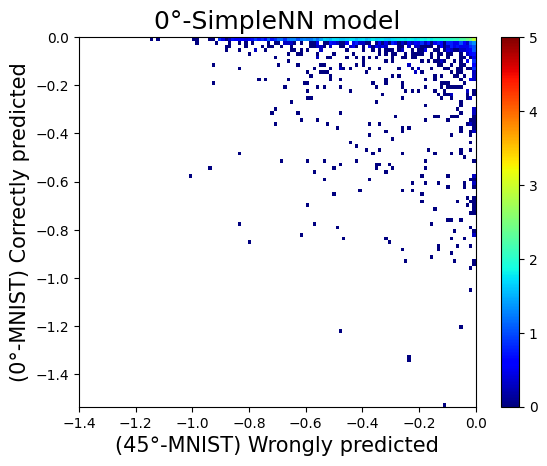

In [114]:
a = np.array(logits_1)[bien_mal_preds]
b = np.array(logits_2)[bien_mal_preds]

assert a.shape==b.shape

plot_hist2d(a, b, what='bien_mal_preds_logits', ylabel='Correctly predicted', xlabel='Wrongly predicted', bins=100, cmap='jet', vmax=5, xlim=[-1.2, 0], ylim=[-1.4, 0], deg_in=0, deg_out=45, log=True, config=None)

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


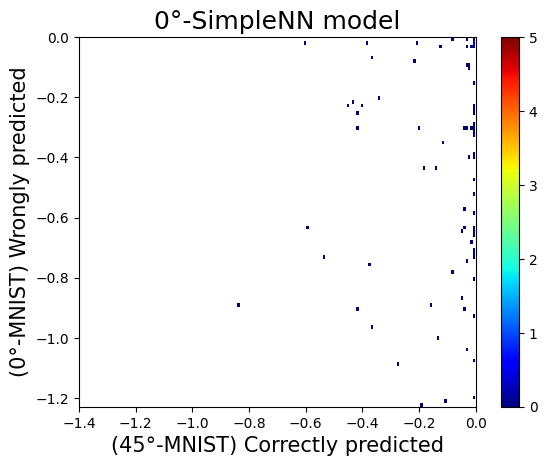

In [115]:
a = np.array(logits_1)[mal_bien_preds]
b = np.array(logits_2)[mal_bien_preds]

assert a.shape==b.shape

plot_hist2d(a, b, what='mal_bien_preds_logits', ylabel='Wrongly predicted', xlabel='Correctly predicted', bins=100, cmap='jet', vmax=5, xlim=[-1.2, 0], ylim=[-1.4, 0], deg_in=0, deg_out=45, log=True, config=None)

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


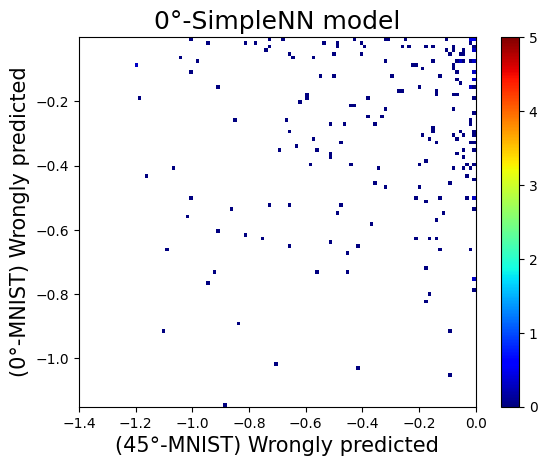

In [116]:
a = np.array(logits_1)[mal_mal_preds]
b = np.array(logits_2)[mal_mal_preds]

assert a.shape==b.shape

plot_hist2d(a, b, what='mal_mal_preds_logits', bins=100, ylabel='Wrongly predicted', xlabel='Wrongly predicted', cmap='jet', vmax=5, xlim=[-1.2, 0], ylim=[-1.4, 0], deg_in=0, deg_out=45, log=True, config=None)

## Visualizing examples depending on the model's predictions

### logits/probabilities histograms with MNIST input examples

In [174]:
def plot_hist2d_BIS(a, b, what, ylabel, xlabel, bins, cmap, vmax, xlim, ylim, deg_in, deg_out, log, xcadrillage, ycadrillage, config):
    H, xedges, yedges = np.histogram2d(a,b,bins=bins) #,range=histRange)
    #H, xedges, yedges = np.histogram2d(m1,m2,bins=10) #,range=histRange)
    #print(xedges, yedges)

    # H needs to be rotated and flipped
    #H = np.rot90(H)
    #H = np.flipud(H)
    
    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    # Log
    if log is True:
        Hmasked = np.log10(Hmasked)     

    # Plot 2D histogram using pcolor
    fig2 = plt.figure()
    #plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')
    plt.pcolormesh(xedges,yedges,Hmasked, cmap=cmap, vmin=0, vmax=vmax)
    plt.colorbar()
    #plt.xticks(range(0,20,200), range(10))
    #plt.yticks(range(10))

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.xlim(ylim)

    rect = plt.Rectangle((0,0), xedges[xcadrillage], yedges[ycadrillage],  #(left, bottom), width, height,
                         facecolor="black", alpha=0.1)

    plt.gca().add_patch(rect)  #ax.add_patch(rect)

    # Cadrillage
    plt.axhline(y=yedges[ycadrillage], linestyle='--', linewidth=1, color='grey')
    plt.axvline(x=xedges[xcadrillage], linestyle='--', linewidth=1, color='grey')

    plt.title('{}°-SimpleNN model'.format(deg_in), fontsize=18)
    plt.ylabel('({}°-MNIST) {}'.format(deg_in, ylabel), fontsize=15)
    plt.xlabel('({}°-MNIST) {}'.format(deg_out, xlabel), fontsize=15)

    # #path = '0_SeparateModel/SeparateModel_SimpleNN_{}deg_how-correct-preds-in-{}deg-MNIST-are-classified-in-{}deg-MNIST.pdf'.format(
    # path = '0_SeparateModel/{}_{}_{}deg_{}_{}deg_in_{}deg_out_BIS.pdf'.format(
    #     config['setting'],
    #     config['model_name'],
    #     deg_in,
    #     what,
    #     deg_in,
    #     deg_out 
    # )
    # plt.savefig(path,bbox_inches='tight')
    # plt.show()

    return ax

In [301]:
def plot_mnist_examples(
    what,
    bien_mal_preds,
    inputs_1, targets_1, logits_1, preds_1,
    inputs_2, targets_2, logits_2, preds_2,
    xcadrillage, ycadrillage,
    xlim=None, ylim=None,
    bins=100,
    ylabel='Correctly predicted', xlabel='Wrongly predicted',
    cmap='jet', #vmax=5, #xlim=[-1.2, 0], ylim=[-1.4, 0],
    deg_in=0, deg_out=45, log=False,
    config=None
    ):
    
    a = np.array(logits_1)[bien_mal_preds]
    b = np.array(logits_2)[bien_mal_preds]

    assert a.shape==b.shape

    H, xedges, yedges = np.histogram2d(a,b,bins=bins) #,range=histRange)
    #H, xedges, yedges = np.histogram2d(m1,m2,bins=10) #,range=histRange)
    with np.printoptions(threshold=np.inf):
        print(xedges, yedges)
        print(H[:50, :50])

    # H needs to be rotated and flipped
    #H = np.rot90(H)
    #H = np.flipud(H)
    
    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    # Log
    if log is True:
        Hmasked = np.log10(Hmasked)     

    # Plot 2D histogram using pcolor
    fig2 = plt.figure()
    #plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')
    plt.pcolormesh(xedges,yedges,Hmasked, cmap=cmap) #, vmin=0, vmax=vmax)
    plt.colorbar()
    #plt.xticks(range(0,20,200), range(10))
    #plt.yticks(range(10))

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.xlim(ylim)

    rect = plt.Rectangle((xedges[xcadrillage], yedges[ycadrillage]), xedges[xcadrillage], yedges[ycadrillage],  #(left, bottom), width, height,
                         facecolor="black", alpha=0.1)

    plt.gca().add_patch(rect)  #ax.add_patch(rect)

    # Cadrillage
    plt.axhline(y=yedges[ycadrillage], linestyle='--', linewidth=1, color='grey')
    plt.axvline(x=xedges[xcadrillage], linestyle='--', linewidth=1, color='grey')

    plt.title('{}°-SimpleNN model'.format(deg_in), fontsize=18)
    plt.ylabel('({}°-MNIST) {}'.format(deg_in, ylabel), fontsize=15)
    plt.xlabel('({}°-MNIST) {}'.format(deg_out, xlabel), fontsize=15)



    ############################################### second part of the plot
    print(xedges[xcadrillage])
    print(yedges[ycadrillage])
    #cond_1 = (np.array(logits_1) <= yedges[ycadrillage]) & bien_mal_preds
    #cond_2 = (np.array(logits_2) <= xedges[xcadrillage]) & bien_mal_preds
    cond_1 = (np.array(logits_1) <= yedges[ycadrillage]) & (np.array(logits_2) <= xedges[xcadrillage]) # & bien_mal_preds

    print(np.array(targets_1)[cond_1])
    print(np.array(preds_1)[cond_1])
    print(np.array(preds_2)[cond_1].shape[0])

    num_images = min(8, np.array(preds_2)[cond_1].shape[0])
    #plt.figure(figsize=(15, 3))
    fig, ax = plt.subplots(nrows=4, ncols=num_images, figsize=(num_images*2, 4*2))

    rng = np.random.default_rng()
    images_and_labels = rng.choice(
        list(zip(
            np.array(inputs_1, dtype=object)[cond_1], np.array(preds_1, dtype=object)[cond_1], np.array(logits_1, dtype=object)[cond_1],
            np.array(inputs_2, dtype=object)[cond_1], np.array(preds_2, dtype=object)[cond_1], np.array(logits_2, dtype=object)[cond_1],
            #np.array(inputs_1, dtype=object)[cond_2], np.array(preds_1, dtype=object)[cond_2], np.array(logits_1, dtype=object)[cond_2],
            #np.array(inputs_2, dtype=object)[cond_2], np.array(preds_2, dtype=object)[cond_2], np.array(logits_2, dtype=object)[cond_2]
            )),
        size=num_images, replace=False)

    for i in range(num_images):
        img1, pred1, logit1, img2, pred2, logit2 = images_and_labels[i]  #,\
            #img1_2, pred1_2, logit1_2, img2_2, pred2_2, logit2_2 = images_and_labels[i]

        #plt.subplot(1, num_images, i+1)
        ax[0, i].imshow(img1[0], cmap='gray')
        ax[0, i].set_title(f'predicted: {pred1}\n proba: {logit1:.3f}')
        ax[0, i].axis('off')

        #plt.subplot(2, num_images, i+1)
        ax[1, i].imshow(img2[0], cmap='gray')
        ax[1, i].set_title(f'predicted: {pred2}\n proba: {logit2:.3f}')
        ax[1, i].axis('off')

        # #plt.subplot(1, num_images, i+1)
        # ax[2, i].imshow(img1_2[0], cmap='gray')
        # ax[2, i].set_title(f'predicted: {pred1_2}\n proba: {logit1_2:.3f}')
        # ax[2, i].axis('off')

        # #plt.subplot(2, num_images, i+1)
        # ax[3, i].imshow(img2_2[0], cmap='gray')
        # ax[3, i].set_title(f'predicted: {pred2_2}\n proba: {logit2_2:.3f}')
        # ax[3, i].axis('off')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

    path = '0_SeparateModel/{}_{}_{}deg_{}_{}deg_in_{}deg_out_BIS.pdf'.format(
        config['setting'],
        config['model_name'],
        deg_in,
        what,
        deg_in,
        deg_out 
    )
    plt.savefig(path,bbox_inches='tight')
    plt.show()


[-1.15004373 -1.13854329 -1.12704285 -1.11554241 -1.10404198 -1.09254154
 -1.0810411  -1.06954067 -1.05804023 -1.04653979 -1.03503935 -1.02353892
 -1.01203848 -1.00053804 -0.9890376  -0.97753717 -0.96603673 -0.95453629
 -0.94303586 -0.93153542 -0.92003498 -0.90853454 -0.89703411 -0.88553367
 -0.87403323 -0.86253279 -0.85103236 -0.83953192 -0.82803148 -0.81653105
 -0.80503061 -0.79353017 -0.78202973 -0.7705293  -0.75902886 -0.74752842
 -0.73602798 -0.72452755 -0.71302711 -0.70152667 -0.69002624 -0.6785258
 -0.66702536 -0.65552492 -0.64402449 -0.63252405 -0.62102361 -0.60952317
 -0.59802274 -0.5865223  -0.57502186 -0.56352143 -0.55202099 -0.54052055
 -0.52902011 -0.51751968 -0.50601924 -0.4945188  -0.48301836 -0.47151793
 -0.46001749 -0.44851705 -0.43701662 -0.42551618 -0.41401574 -0.4025153
 -0.39101487 -0.37951443 -0.36801399 -0.35651356 -0.34501312 -0.33351268
 -0.32201224 -0.31051181 -0.29901137 -0.28751093 -0.27601049 -0.26451006
 -0.25300962 -0.24150918 -0.23000875 -0.21850831 -0.2

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:82: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:83: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you

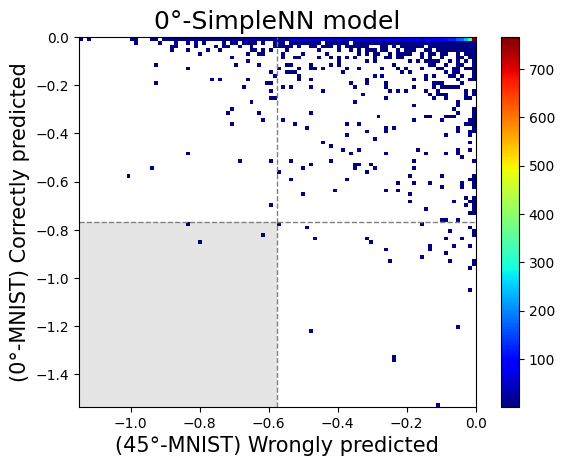

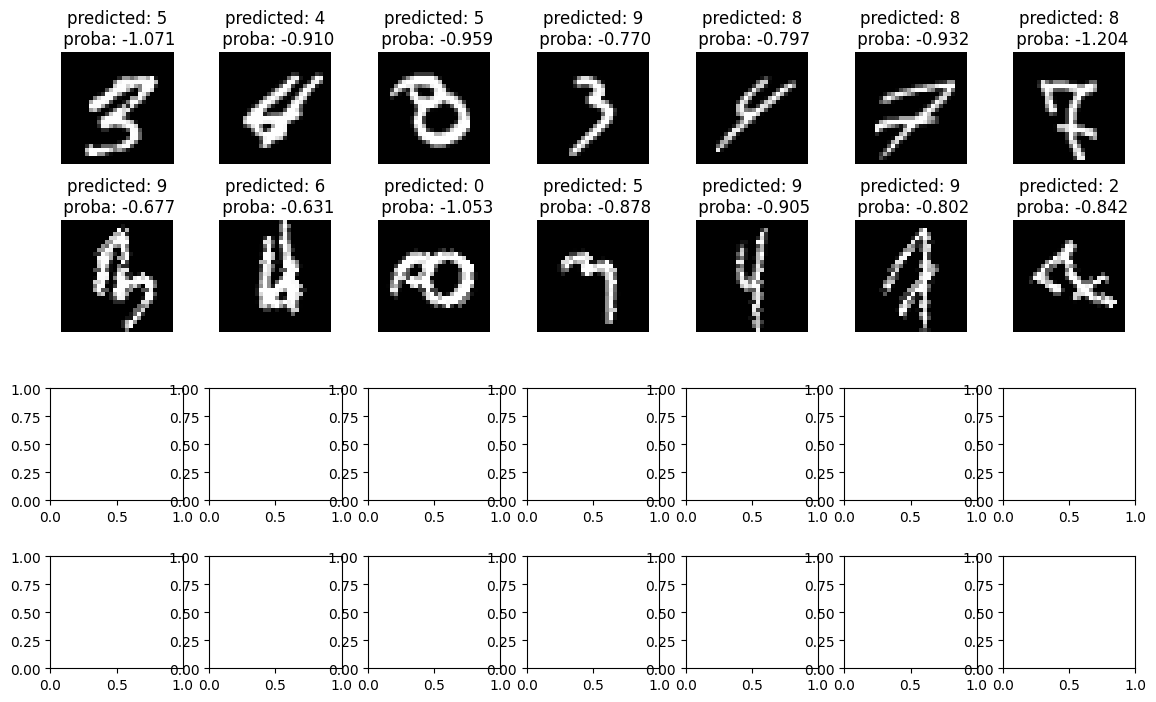

In [302]:
'''
a = np.array(logits_1)[bien_mal_preds]
b = np.array(logits_2)[bien_mal_preds]

assert a.shape==b.shape

plot_hist2d(a, b, what='bien_mal_preds_logits', ylabel='Correctly predicted', xlabel='Wrongly predicted', bins=100, cmap='jet', vmax=5, xlim=[-1.2, 0], ylim=[-1.4, 0], deg_in=0, deg_out=45, log=True, xcadrillage=30, ycadrillage=30, config=config)
'''

plot_mnist_examples(
    'bien_mal_preds_logits',
    bien_mal_preds,
    inputs_1, targets_1, logits_1, predictions_1,
    inputs_2, targets_2, logits_2, predictions_2,
    xcadrillage=50, ycadrillage=50,
    config=config)


#### misc tests

In [76]:
a = np.array(logits_1)[mal_mal_preds]
b = np.array(logits_2)[mal_mal_preds]

assert a.shape==b.shape
H, xedges, yedges = np.histogram2d(a,b,bins=200) #,range=histRange)

In [77]:
print(xedges)

[-1.20373380e+00 -1.19771602e+00 -1.19169824e+00 -1.18568046e+00
 -1.17966268e+00 -1.17364490e+00 -1.16762712e+00 -1.16160934e+00
 -1.15559156e+00 -1.14957378e+00 -1.14355600e+00 -1.13753822e+00
 -1.13152044e+00 -1.12550266e+00 -1.11948488e+00 -1.11346711e+00
 -1.10744933e+00 -1.10143155e+00 -1.09541377e+00 -1.08939599e+00
 -1.08337821e+00 -1.07736043e+00 -1.07134265e+00 -1.06532487e+00
 -1.05930709e+00 -1.05328931e+00 -1.04727153e+00 -1.04125375e+00
 -1.03523597e+00 -1.02921819e+00 -1.02320041e+00 -1.01718263e+00
 -1.01116485e+00 -1.00514707e+00 -9.99129289e-01 -9.93111509e-01
 -9.87093730e-01 -9.81075950e-01 -9.75058170e-01 -9.69040390e-01
 -9.63022610e-01 -9.57004831e-01 -9.50987051e-01 -9.44969271e-01
 -9.38951491e-01 -9.32933711e-01 -9.26915932e-01 -9.20898152e-01
 -9.14880372e-01 -9.08862592e-01 -9.02844812e-01 -8.96827033e-01
 -8.90809253e-01 -8.84791473e-01 -8.78773693e-01 -8.72755914e-01
 -8.66738134e-01 -8.60720354e-01 -8.54702574e-01 -8.48684794e-01
 -8.42667015e-01 -8.36649

In [89]:
H

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 3., 3.]])

In [79]:
print(np_targets_1[(np.array(logits_1)<=xedges[50]) & (np.array(logits_2)<=yedges[50])])
print(np_preds_1[(np.array(logits_1)<=xedges[0]) & mal_mal_preds])

[8]
[8]


In [30]:
def get_examples(test_loader):
    inpts, targets = [], []
    for inputs, labels in test_loader:

        inpts.extend(inputs)
        targets.extend(labels)

    return np.array(inpts, dtype=object), np.array(targets)

In [31]:
inpts_1, trgts_1 = get_examples(test_loader_1['loader'])
inpts_2, trgts_2 = get_examples(test_loader_2['loader'])

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  


[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


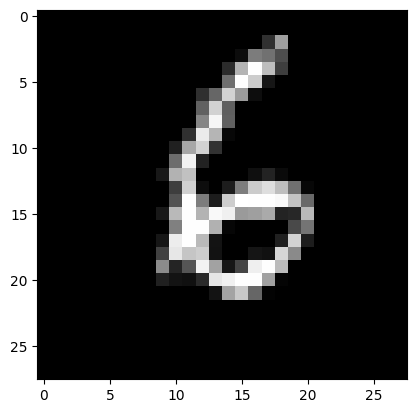

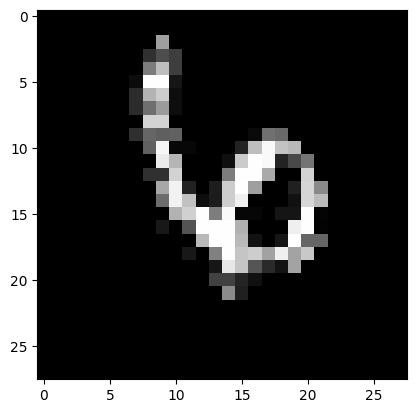

(195,)


In [32]:
print(trgts_1)
print(trgts_2)

plt.imshow(inpts_1[2000][0], cmap='gray')
plt.show()
plt.imshow(inpts_2[2000][0], cmap='gray')
plt.show()


print(np.array(inpts_1)[mal_mal_preds].shape)

[8]
[7]
torch.Size([1, 28, 28])


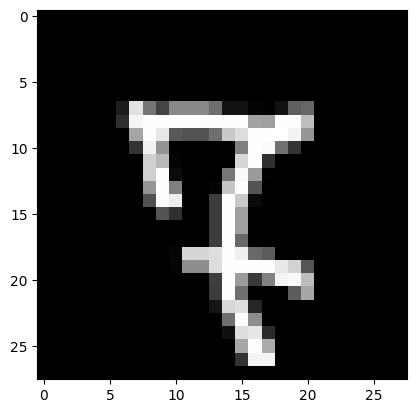

In [33]:
cond = (np.array(logits_1)<=xedges[0]) & mal_mal_preds

print(np_preds_1[cond])
print(trgts_1[cond])

print(inpts_1[cond][0].shape)
plt.imshow(inpts_1[cond][0][0], cmap='gray')
plt.show()

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


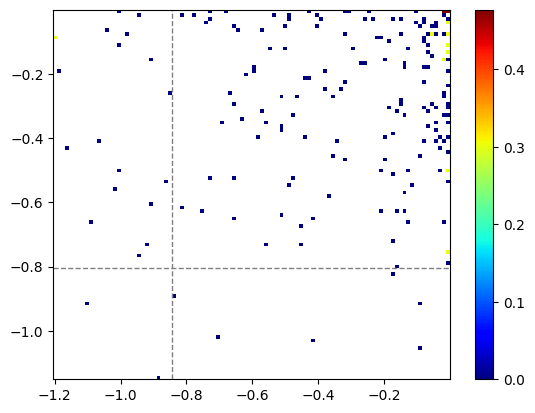

In [80]:
a = np.array(logits_1)[mal_mal_preds]
b = np.array(logits_2)[mal_mal_preds]

assert a.shape==b.shape


H, xedges, yedges = np.histogram2d(a,b,bins=100) #,range=histRange)

# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
# Log
#if log is True:
#    Hmasked = np.log10(Hmasked)     
Hmasked = np.log10(Hmasked)     

# Plot 2D histogram using pcolor
fig2 = plt.figure()
plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')  #, vmin=0, vmax=800)
plt.colorbar()
#plt.xticks(range(0,20,200), range(10))
#plt.yticks(range(10))

# Cadrillage
plt.axhline(y=yedges[30], linestyle='--', linewidth=1, color='grey')
plt.axvline(x=xedges[30], linestyle='--', linewidth=1, color='grey')

# plt.title('{}°-SimpleNN model'.format(deg_in), fontsize=18)
# plt.ylabel('({}°-MNIST) {}'.format(deg_in, ylabel), fontsize=15)
# plt.xlabel('({}°-MNIST) {}'.format(deg_out, xlabel), fontsize=15)
# path = '0_SeparateModel/SeparateModel_SimpleNN_{}deg_{}_{}deg_in_{}deg_out.pdf'.format(
#     deg_in,
#     what,
#     deg_in,
#     deg_out 
# )
# plt.savefig(path)
plt.show()

In [85]:
a = np.array(logits_1)[mal_mal_preds]
b = np.array(logits_2)[mal_mal_preds]

assert a.shape==b.shape

H, xedges, yedges = np.histogram2d(a,b,bins=100) #,range=histRange)

H[:30, :30]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

[8 5 5 8 5 8 0 5]
[7 8 9 7 9 6 2 3]
number of examples wrongly classified before and after rotation shift is (195,)


/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


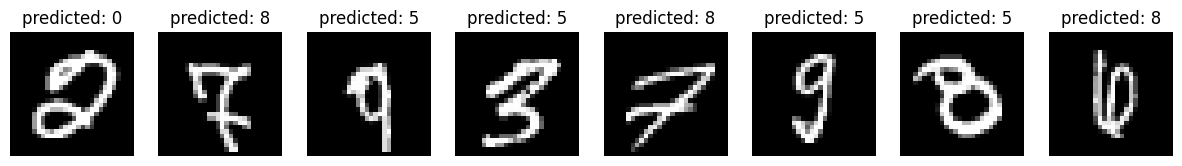

In [110]:
a = np.array(logits_1)[mal_mal_preds]
b = np.array(logits_2)[mal_mal_preds]

assert a.shape==b.shape

H, xedges, yedges = np.histogram2d(a,b,bins=100) #,range=histRange)


cond_1 = (np.array(logits_1)<=xedges[30]) & mal_mal_preds
cond_2 = (np.array(logits_2)<=yedges[30]) & mal_mal_preds

print(np_preds_1[cond_1])
print(trgts_1[cond_1])
print(np.where(mal_mal_preds==True)[0])


plt.figure(figsize=(15, 3))

num_images = 8 
rng = np.random.default_rng()
images_and_labels = rng.choice(list(zip(inpts_1[cond_1], np_preds_1[cond_1])), size=num_images, replace=False)

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    img, pred = images_and_labels[i]
    plt.imshow(img[0], cmap='gray')
    plt.title(f'predicted: {pred}')
    plt.axis('off')

plt.show()

### tests on logits (not probabilities!)

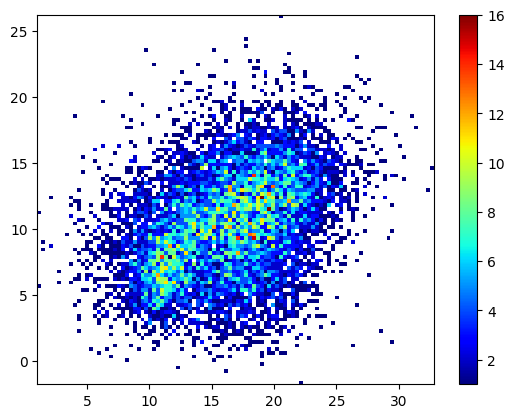

In [ ]:
H, xedges, yedges = np.histogram2d(np.array(logits_1),np.array(logits_2),bins=100) #,range=histRange)
#H, xedges, yedges = np.histogram2d(m1,m2,bins=10) #,range=histRange)
#print(xedges, yedges)

# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
 
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
# Log
#Hmasked = np.log10(Hmasked)     

# Plot 2D histogram using pcolor
fig2 = plt.figure()
#plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')
plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')
plt.colorbar()
#plt.xticks(range(0,20,200), range(10))
#plt.yticks(range(10))
plt.show()

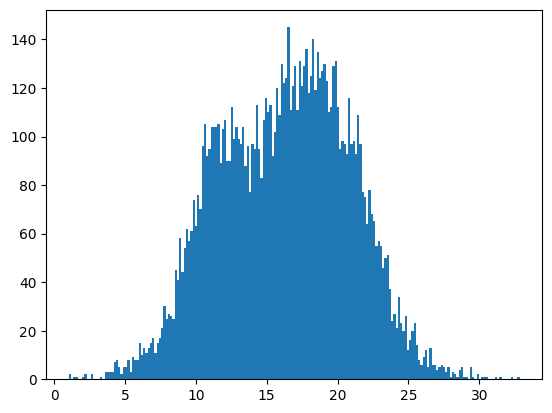

In [ ]:
plt.hist(np.array(logits_1), bins=200)
plt.show()